In [1]:
using Random,OrdinaryDiffEq, DiffEqFlux, Optim, LineSearches, Plots
using MatrixFreeNewton
gr()
include("utils.jl")
include("models.jl")


AbstractNROrbitModel1 (generic function with 1 method)

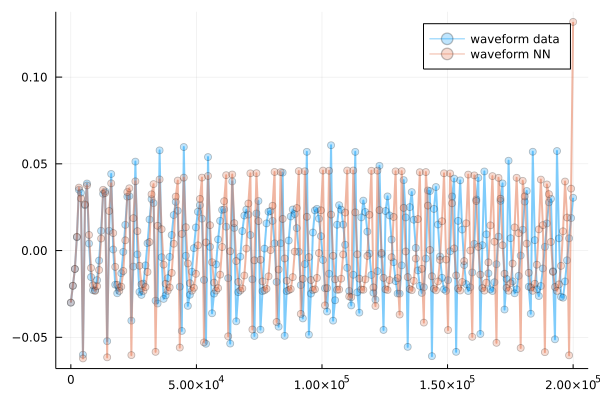

Size of nn parameters: (338,)


loss (generic function with 1 method)

In [2]:
## Define the experimental parameters
mass_ratio = 0.0
u0 = Float64[pi, 0.0]
datasize = 250
tspan = (0.0f0, 20.0f4)
tsteps = range(tspan[1], tspan[2], length = datasize)
dt_data = tsteps[2] - tsteps[1]
dt = 100.0
model_params = [100.0, 1.0, 0.5] # p, M, e

# Generate waveform data
prob = ODEProblem(RelativisticOrbitModel, u0, tspan, model_params)
soln = Array(solve(prob, RK4(), saveat = tsteps, dt = dt, adaptive=false))
waveform = compute_waveform(dt_data, soln, mass_ratio, model_params)[1]

plt = plot(tsteps, waveform,
           markershape=:circle, markeralpha = 0.25,
           linewidth = 2, alpha = 0.5,
           label="waveform data")

## Define neural network model
n_hidden = 16
NN = FastChain((x, p) -> [cos(x[1])],
                FastDense(1, n_hidden, cos),
                FastDense(n_hidden, n_hidden, cos),
                FastDense(n_hidden, 2))
NN_params = initial_params(NN) .* 0

println("Size of nn parameters: ",size(NN_params))

function ODE_model(u, NN_params, t)
    du = AbstractNNOrbitModel(u, model_params, t, NN=NN, NN_params=NN_params)
    return du
end

prob_nn = ODEProblem(ODE_model, u0, tspan, NN_params)
soln_nn = Array(solve(prob_nn, RK4(), u0 = u0, p = NN_params, saveat = tsteps, dt = dt, adaptive=false))
waveform_nn = compute_waveform(dt_data, soln_nn, mass_ratio, model_params)[1]

plot!(plt, tsteps, waveform_nn,
           markershape=:circle, markeralpha = 0.25,
           linewidth = 2, alpha = 0.5,
           label="waveform NN")
display(plt)

## Define objective function
function loss(NN_params)
    # Here is where to try different adjoints
    pred = Array(solve(prob_nn, RK4(), u0 = u0, p = NN_params, saveat = tsteps, dt = dt, adaptive=false))
    pred_waveform = compute_waveform(dt_data, pred, mass_ratio, model_params)[1]
    loss = ( sum(abs2, waveform .- pred_waveform) )
    return loss
end

In [3]:
iterations = 20
lrsfn_rank = 40

# Allocate logger dictionaries for seeding
loggers_gd = Dict()
loggers_lrsfn = Dict()
# 
loggers_bfgs = Dict()
struct BFGSLogger
    alpha::Float64
    losses::AbstractArray{Float64}
end

NN_params = initial_params(NN) .* 0
random_state = Random.MersenneTwister(0)
w_0 = copy(NN_params + 1e-4*randn(random_state,eltype(NN_params), size(NN_params)))

for seed in 0:10
    println("Running for seed ",seed)
    random_state = Random.MersenneTwister(seed)
    w_0 = copy(NN_params + 1e-4*randn(random_state,eltype(NN_params), size(NN_params)))

    println("Now for gradient descent ")
    w_star_gd,logger_gd = gradientDescent(loss,w_0,alpha = 1e-5, iterations = iterations,printing_frequency = 1)
    loggers_gd[seed] = logger_gd
    
    
    println("Now for low rank SFNewton with reduced Hessian with LRSFN rank = ",lrsfn_rank)
    w_star_lrsfn,logger_lrsfn = lowRankSaddleFreeNewton(loss,w_0,rank=40,printing_frequency = 1,
                                        alpha = 5e-1,gamma = 1e-4,hessian = "matrix_free",iterations = iterations)

    loggers_lrsfn[seed] = logger_lrsfn
    
    # BFGS
    println("Now for BFGS")
    global losses_bfgs = zeros(0)
    global iter = 0
    cb = function(p,l)
        global iter += 1 
        println("Loss at iter ",iter," = ",l)
        append!(losses_bfgs,l)
        return false
    end
    alpha_bfgs = 0.025
    res = DiffEqFlux.sciml_train(loss, w_0, BFGS(initial_stepnorm=0.025),
                                            maxiters = iterations,progress = true,cb = cb)
    println("Losses for BFGS", losses_bfgs)
    logger_bfgs = BFGSLogger(alpha_bfgs,losses_bfgs)
    loggers_bfgs[seed] = logger_bfgs
    
end
println("Done")

Running for seed 0
Now for gradient descent 
At initial guess obj = 0.26503443531553883
At iteration 1 obj = 0.2576701827281887
At iteration 2 obj = 0.24312116306737808
At iteration 3 obj = 0.2379238123048802
At iteration 4 obj = 0.23252857700174248
At iteration 5 obj = 0.22644087631783397
At iteration 6 obj = 0.21945854614042756
At iteration 7 obj = 0.21141090456813205
At iteration 8 obj = 0.20206226459897406
At iteration 9 obj = 0.19077096318103584
At iteration 10 obj = 0.17500490165892105
At iteration 11 obj = 0.14592874779549153
At iteration 12 obj = 0.096463028205255
At iteration 13 obj = 0.05386104891995758
At iteration 14 obj = 0.021532192769093732
At iteration 15 obj = 0.006342630267524066
At iteration 16 obj = 0.0017081163750289788
At iteration 17 obj = 0.00048061254749928267
At iteration 18 obj = 0.00016227929390450025
At iteration 19 obj = 7.885323016963465e-5
At iteration 20 obj = 5.672416920492025e-5
At iteration 21 obj = 5.0715066457648356e-5
At iteration 22 obj = 4.90168

In [10]:
using NPZ, Statistics
# Save data for post-processing
data_dir = "emr_data/"
if ~isdir(data_dir)
    mkdir(data_dir)
end
problem_name = "emr"
optimizers = ["gd","lrsfn","bfgs"]
logger_dicts = [loggers_gd,loggers_lrsfn,loggers_bfgs]

for (optimizer,logger_dict) in zip(optimizers,logger_dicts)
    println("optimizer = ",optimizer)
    opt_losses = zeros(0)
    for (seed,logger) in logger_dict
        name = problem_name*optimizer*"_alpha_"*string(logger.alpha)*"_"*string(seed)
        if optimizer == "lrsfn"
            name *="rank_"*string(logger.rank)
        end
        println("name = ",name)
        # Save losses
        npzwrite(data_dir*name*"_losses.npy",logger.losses)
        min_loss = minimum(logger.losses)
        append!(opt_losses,min_loss)
        # If sfn save spectrum:
        if optimizer in ["sfn","lrsfn"]

            npzwrite(data_dir*name*"_spectra.npy",logger.spectra)
        end
        # If csgd save alphas
        if optimizer in ["csgd"]
            npzwrite(data_dir*name*"_alphas.npy",logger.alphas)
        end

    end
    println("Min min loss = ",minimum(opt_losses))
    println("Avg min loss = ",Statistics.mean(opt_losses))
    println("Std min loss = ",Statistics.std(opt_losses,corrected = false))
end

optimizer = gd
name = emrgd_alpha_1.0e-5_0
Min min loss = 4.816270504588256e-5
Avg min loss = 4.816270504588256e-5
Std min loss = 0.0
optimizer = lrsfn
name = emrlrsfn_alpha_0.8_0rank_40.0
Min min loss = 4.816270473404493e-5
Avg min loss = 4.816270473404493e-5
Std min loss = 0.0
optimizer = bfgs
name = emrbfgs_alpha_0.025_0
Min min loss = 4.8162704734191594e-5
Avg min loss = 4.8162704734191594e-5
Std min loss = 0.0
